# Time Series Clustering

**Data**
* Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below
* The data is on the github repo. Each file is the economic census for 1 year. Download it programmatically and move it to PUIdata
* Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
 
**Outline**:
    
1. get and prep your data.
2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)    
3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
4. Use another clustering algorithm (of your choice)
5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
6. Compare the results of the 2 algorithms
7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    


In [509]:
import numpy as np
import pandas as pd
import geopandas as gp
import zipfile
import os
import scipy.cluster as scp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
%matplotlib inline
from sklearn.cluster import KMeans, AgglomerativeClustering

In [510]:
puidata = os.getenv("PUIDATA")
files=[]

#moving files to PUIDATA folder
for i in (range(1994,2015)):
    i = str(i)[-2:]
    data_url = 'https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/zbp%02dtotals.zip'% int(i)
    filename = data_url.split('/')[-1]
    files.append(filename)
    os.system("curl -O " + data_url)
    os.system("mv " + filename + " " + puidata)
    
print(files)

['zbp94totals.zip', 'zbp95totals.zip', 'zbp96totals.zip', 'zbp97totals.zip', 'zbp98totals.zip', 'zbp99totals.zip', 'zbp00totals.zip', 'zbp01totals.zip', 'zbp02totals.zip', 'zbp03totals.zip', 'zbp04totals.zip', 'zbp05totals.zip', 'zbp06totals.zip', 'zbp07totals.zip', 'zbp08totals.zip', 'zbp09totals.zip', 'zbp10totals.zip', 'zbp11totals.zip', 'zbp12totals.zip', 'zbp13totals.zip', 'zbp14totals.zip']


In [511]:
# merge into single time series for each zip
firstfile = puidata + "/" + files[0]
zf = zipfile.ZipFile(firstfile)
df = pd.read_csv(zf.open(files[0].replace('.zip','.txt')), 
                 usecols=['zip','est'])

for f in files[1:]:
    year=f[3:5]
    fname = puidata + "/" + f
    zf = zipfile.ZipFile(fname)
    df2 = pd.read_csv(zf.open(f.replace('.zip','.txt')))
    df2.columns = map(str.lower, df2.columns)
    df = df.merge(df2[['zip','est']], on='zip', how='outer', suffixes=['',year]) #outer is important here or else you lose many stations

df.head()

,zip,est,est95,est96,est97,est98,est99,est00,est01,est02,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,1001.0,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1,1002.0,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
2,1003.0,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0
3,1004.0,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0,13.0
4,1005.0,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0,97.0


In [512]:
# rename columns
cdict = {}
columnlist = ['zip'] + list(range(1994,2015))
for i in range(len(columnlist)):
    cdict[df.columns[i]] = columnlist[i]

df.rename(columns=cdict, inplace=True)    
df.head()

,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,1001.0,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1,1002.0,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
2,1003.0,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0
3,1004.0,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0,13.0
4,1005.0,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0,97.0


In [513]:
#Download zip shapefile
os.system("curl -O https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip")
os.system("unzip ZIP_CODE_040114.zip -d " + puidata)

2304

### Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info. **sanity check**: you should have 20 N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. After that:
* mydata.shape should be (Nzipcodes, Ntimestamps)
* mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))
* mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [514]:
nyczipsshp = gp.read_file(puidata + "/ZIP_CODE_040114.shp")

print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [515]:
# 20 years of data and 263 zipcodes
cbs = df[df.zip.isin(nyczips)]
cbs.shape

(245, 22)

In [516]:
# What zips are missing?
[ n for n in nyczips if n not in list(cbs.zip) ]

[83, 10097, 10259]

In [517]:
#set index to 'zips'
cbs.set_index('zip', inplace=True)

In [518]:
#rolling window as option... does not get rid of nan values
cleancbs = cbs.rolling(3, axis=1, center=True).mean()
r14 = cbs.rolling(2,axis=1,center=True).mean()
cleancbs[1994] = cbs[1994]
cleancbs[2014] = r14[2014]
cleancbs.fillna(0)
cleancbs.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001.0,6999.0,7054.000000,7105.666667,7161.000000,7213.666667,7268.000000,7246.000000,7215.333333,7137.666667,7198.333333,...,7365.666667,7425.333333,7478.666667,7442.000000,7339.333333,7257.666667,7234.333333,7245.000000,7292.333333,7321.0
10002.0,1784.0,1840.666667,1929.000000,1990.333333,2045.666667,2121.666667,2301.666667,2363.000000,2404.666667,2407.333333,...,2639.666667,2684.333333,2687.333333,2717.000000,2779.333333,2853.000000,2912.666667,2951.333333,2971.333333,2980.0
10003.0,3256.0,3350.000000,3443.000000,3533.666667,3614.333333,3663.666667,3648.000000,3633.666667,3640.666667,3698.666667,...,3850.666667,3941.666667,4009.666667,4073.000000,4094.333333,4123.666667,4162.000000,4216.666667,4274.666667,4305.0
10004.0,1115.0,1124.000000,1143.333333,1160.666667,1194.000000,1234.333333,1258.000000,1264.666667,1250.666667,1262.666667,...,1284.666667,1313.666667,1352.333333,1375.000000,1384.333333,1393.666667,1414.666667,1441.666667,1491.666667,1516.5
10005.0,1076.0,1133.666667,1184.000000,1237.666667,1246.333333,1266.333333,1259.333333,1260.000000,1231.000000,1223.333333,...,1233.000000,1248.666667,1274.333333,1279.333333,1277.000000,1280.333333,1280.000000,1290.000000,1296.666667,1308.5


In [519]:
cleancbs.isnull().sum()

1994     5
1995     8
1996     9
1997     8
1998    10
1999     9
2000     9
2001     7
2002     8
2003     9
2004     8
2005     8
2006     7
2007     6
2008     5
2009     5
2010     6
2011     6
2012     6
2013     7
2014     7
dtype: int64

In [520]:
# fill na with average of time series
cleancbs = cbs.copy()
m = cleancbs.mean(axis=1)
for i, col in enumerate(cleancbs):
    cleancbs.iloc[:, i] = cleancbs.iloc[:, i].fillna(m)

In [521]:
cleancbs.isnull().sum()

1994    0
1995    0
1996    0
1997    0
1998    0
1999    0
2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
dtype: int64

In [522]:
#cleaning all missing values
cleancbs.shape

(245, 21)

In [523]:
#then the standardization will look like:
vals = ((cleancbs.T - cleancbs.mean(1)) / cleancbs.std(1)).T

In [524]:
#  What values are dropped with vals?
ziplist = cbs.reset_index()
vals.dropna(inplace=True)
vals.reset_index(inplace=True)
[ n for n in list(ziplist.zip) if n not in list(vals.zip) ]

[10196.0, 10203.0]

**Note** The two zip codes above have a population of 0, so makes sense that they should be dropped

* vals.mean(axis=1) should return 0 (or something very small) everywhere
* vals.mean(axis=1).shape should be (260,)
* vals.std(axis=1) should return 1 everywhere
* vals.std(axis=1).shape

In [ ]:
#zips can't be included in classifier
vals.set_index('zip', inplace=True)

## K Means Clustering

In [633]:
#cluster with kmeans
nc=5
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [634]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(243,)

In [635]:
joinme = vals.reset_index()
joinme['cluster'] = km.labels_
joinme.head()

,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,cluster
0,10001.0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,2
1,10002.0,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0
2,10003.0,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,0
3,10004.0,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0
4,10005.0,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,2


In [636]:
#fix zip for join
joinme['zip'] = joinme.zip.astype(int)
joinme['zip'] = joinme.zip.astype(str)
joinme.head()

,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,cluster
0,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,2
1,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0
2,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,0
3,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0
4,10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,2


In [638]:
#merge so we can visualize cluster
nyczipsJoined = nyczipsshp.merge(joinme[['zip','cluster']], left_on='ZIPCODE', right_on='zip', how='outer')

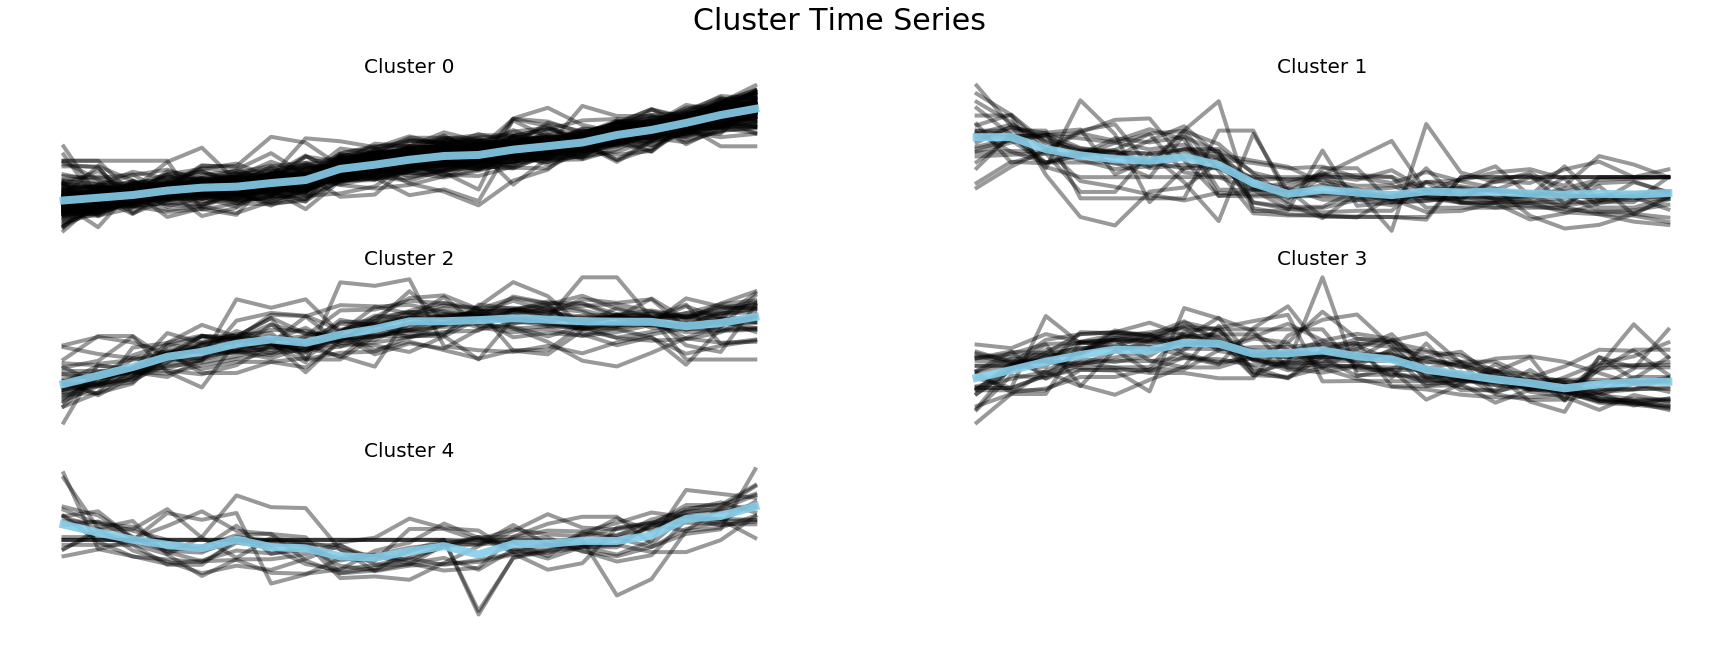

In [637]:
plt.figure(figsize=(30,10))
plt.suptitle('Cluster Time Series', fontsize=30)
N=320
for x in range(5):
    N+=1
    plt.subplot(N)
    pretty = joinme[joinme.cluster == x]
    for i in range(len(pretty)):
        plt.plot(range(1994,2015), pretty.iloc[i][1:-1], c='k', alpha=0.4, lw=4)
    plt.plot(range(1994,2015), pretty.mean()[1:-1], c='skyblue', alpha=0.9, lw=8)
    plt.axis('off')
    plt.title('Cluster {}'.format(x), fontsize=20)

**Figure 1**: Time Series of zip code clusters using K Means. We can see that the mean of each cluster time series(the blue line) has a much different shape. Some are positive, some are negative, some are convex, some are concave, etc. However, also notice that we have many more zip codes that fall into the 1st cluster (0) vs the 5th cluster (4)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Text(0.5,1,'Zip Code Business Pattern Clusters (5)')

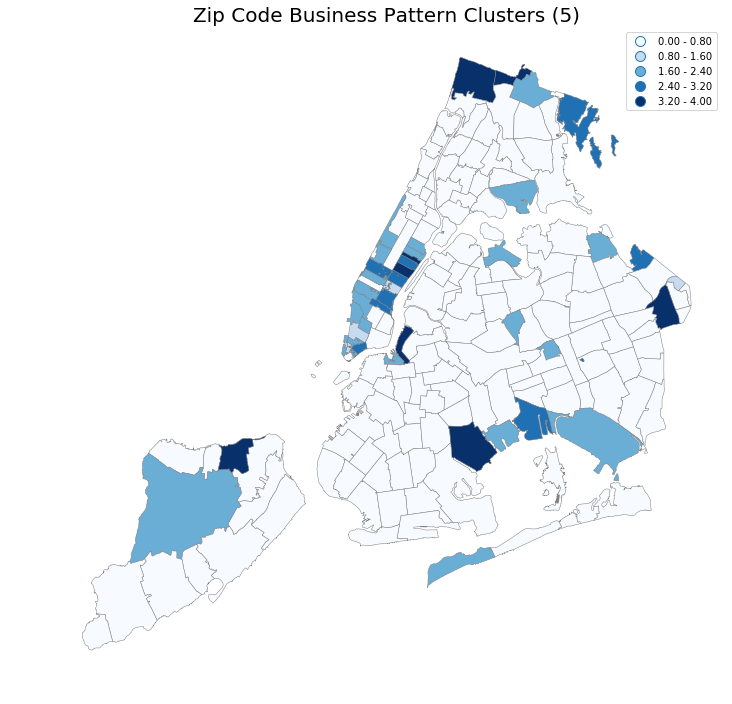

In [639]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

nyczipsJoined.plot(column='cluster', cmap='Blues', ax=ax, legend=True, 
                   scheme='equal_interval', k=5, edgecolor='grey', lw=0.5)
plt.axis('off')
plt.title('Zip Code Business Pattern Clusters (5)', fontsize=20)


**Figure 2:** Cloropleth of cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted in Figure 1. Subprisingly, the Williamsburg waterfront falls into the same cluster as places farther out in the outer boroughs.

## Agglomerative Clustering

In [618]:
agvals = vals.copy()

In [619]:
agc = AgglomerativeClustering(n_clusters=5, linkage='average').fit(agvals)
labelsag = agc.labels_
centroidsag = np.zeros((5, agvals.shape[1]))

In [620]:
agvals['cluster'] = labelsag
agvals.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,cluster
zip,,,,,,,,,,,,,,,,,,,,,
10001.0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0
10002.0,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0
10003.0,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,0
10004.0,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0
10005.0,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,0


In [621]:
# Join clusters to zip codes
nyczipsJoined2 = nyczipsJoined.drop('cluster', axis=1)
agvals.reset_index(inplace=True)
agvals['zip'] = agvals.zip.astype(int)
agvals['zip'] = agvals.zip.astype(str)
nyczipsJoined2 = nyczipsJoined2.merge(agvals[['zip','cluster']], 
                                      left_on='ZIPCODE', right_on='zip', how='outer')

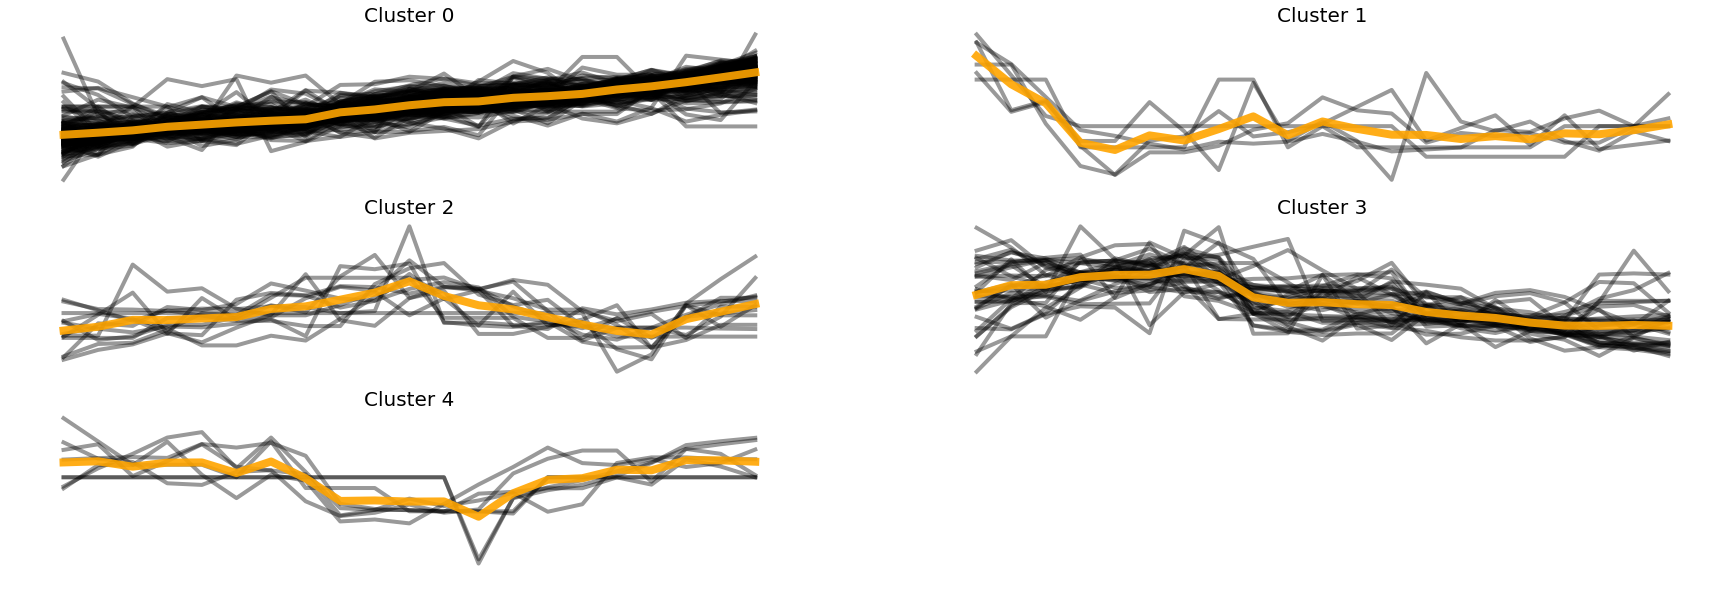

In [624]:
plt.figure(figsize=(30,10))
N=320
for x in range(5):
    N+=1
    plt.subplot(N)
    pretty = agvals[agvals.cluster == x]
    for i in range(len(pretty)):
        plt.plot(range(1994,2015), pretty.iloc[i][1:-1], c='k', alpha=0.4, lw=4)
    plt.plot(range(1994,2015), pretty.mean()[1:-1], c='orange', alpha=0.9, lw=8)
    plt.axis('off')
    plt.title('Cluster {}'.format(x), fontsize=20)

**Figure 3:** Here I am instead using an agglomerative clustering technique with 5 clusters. I also tested out 3, 7, & 9 clusters. I found that when I increased n to 7 & 9 clusters, many of my clusters didn't have many time series. Like the k-means clustering, we can see that cluster 0 in this case contains many more zip code time series than any other.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


(905410.75604293647,
 1075212.5382562785,
 112386.35181947277,
 280345.45402395504)

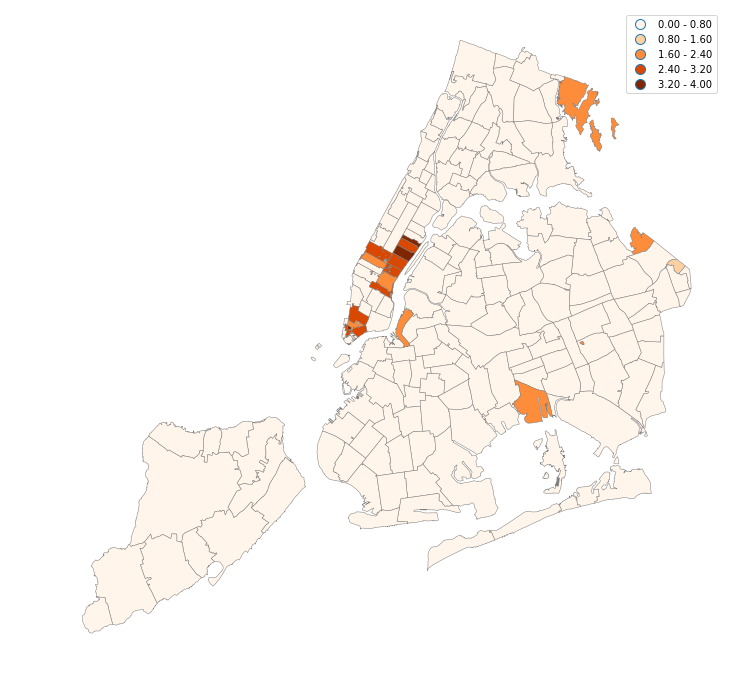

In [625]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

nyczipsJoined2.plot(column='cluster', cmap='Oranges', ax=ax, legend=True, 
                   scheme='equal_interval', k=5, edgecolor='grey', lw=0.5)
plt.axis('off')

**Figure 4:** A choloropleth of hierarchal (agglomerative) clustering with 5 clusters. We can see that in comparison to our K-means map of equal clusters, our clusters are less equally sized. In other words, more zip codes are grouped into the first cluster. 

## Dendrogram of Hierarchical Clusters

In [586]:
zipcodes = vals.reset_index()
zipcodes['zip'] = zipcodes.zip.astype(int)
zipcodes['zip'] = zipcodes.zip.astype(str)
zipcodes = np.array(zipcodes.zip)

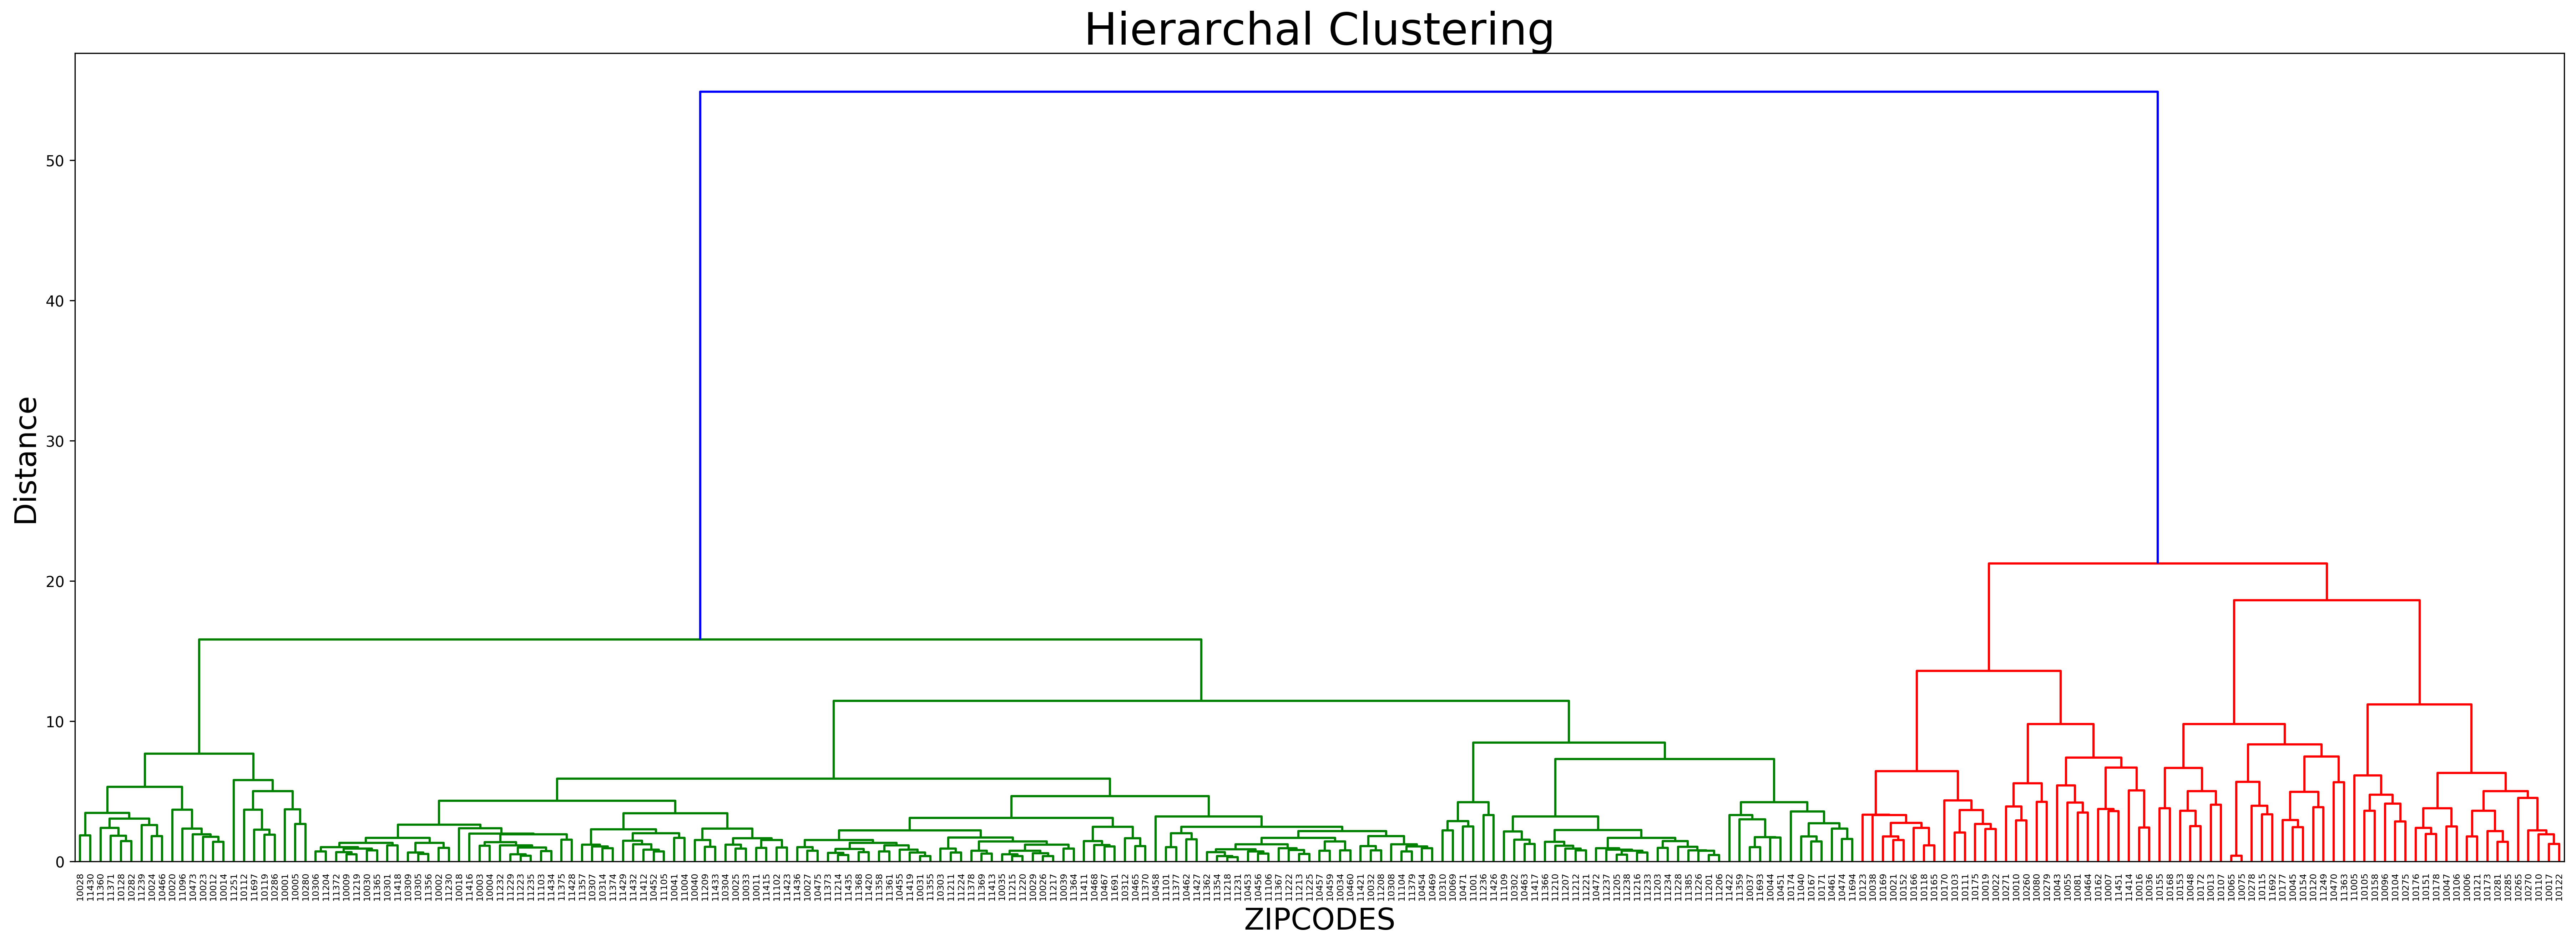

In [597]:
fig = plt.figure(figsize=(30,10), dpi=300)
plt.ylabel("Distance", fontsize=20)
plt.xlabel("ZIPCODES", fontsize=20)
plt.title('Hierarchal Clustering', fontsize=30)
# plt.axis('off')

ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = zipcodes,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=6.,
                              orientation='top')  # font size for the x axis labels)

plt.savefig('HierarchalClustering.png')

**Figure 5:** This Dendrogram gives further proof that our clusters are much less equally distributed using aggolomerative (i.e. "bottom up") hierarchal clustering techniques. Notice that the green cluster takes up a wider range of space than the red cluster (@ N=2). As we move down the green 'branch', the next division on the right still takes up over half of the x-axis. This is most likely cluster 0 in Figures 4 & 5. 

**Interpretation**
It is difficult to interpret which of these two techniques (K-mean vs Agglomerative) is the right choice for our analysis. As noted above, K-means results in more equal distribution of time series amongst clusters. However, K-means is non-deterministic and depended on what my random-state was when calling the function. When I changed the state, the output map looked different every time. An agglomerative approach may be better since it is a bottom up approach. We can also use a dendrogram to choose the number of cluster to use, vs K-means in which you have to choose the number of clusters up front.